In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

import matplotlib.pyplot as plt
import re
import pandas as pd
from pathlib import Path
import torch

from fastprogress import master_bar, progress_bar
%config InlineBackend.figure_format ='retina'

In [2]:
import math
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
def gem(x, p=3, eps=1e-5):
    return torch.abs(F.avg_pool2d(x.clamp(min=eps, max=1e4).pow(p), (x.size(-2), x.size(-1))).pow(1./p))
class L2Norm(nn.Module):
    def __init__(self):
        super(L2Norm,self).__init__()
        self.eps = 1e-10
    def forward(self, x):
        norm = torch.sqrt(torch.sum(x * x, dim = 1) + self.eps)
        x= x / norm.unsqueeze(1).expand_as(x)
        return x

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=torch.clamp(self.p, min=0.1), eps=self.eps)
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class RingHead(nn.Module):
    def __init__(self, num_classes, feat_dim, in_feat = 1024, r_init =1.5):
        super(RingHead,self).__init__()
        self.eps = 1e-10
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.feature_extractor = nn.Sequential(
                        nn.ReLU(),
                        GeM(3.74), Flatten(),
                        nn.BatchNorm1d(in_feat, eps=1e-05, momentum=0.1,
                                                       affine=True, track_running_stats=True),
                        nn.Dropout(p=0.3),
                        nn.Linear(in_features=in_feat, out_features=feat_dim, bias=True),
                        nn.CELU(inplace=True),
                        nn.BatchNorm1d(feat_dim,eps=1e-05, momentum=0.1,
                                                       affine=True, track_running_stats=True))
        
        self.ring =  nn.Parameter(torch.ones(1).cuda()*r_init)
        self.clf = nn.Sequential(nn.Dropout(p=0.5),
                        nn.Linear(in_features=feat_dim, out_features=num_classes, bias=False))
    def forward(self, x):
        feats = self.feature_extractor(x)
        preds = self.clf(feats)
        return preds,feats

class RingGeMNet(nn.Module):
    def __init__(self, new_model, n_classes, in_feats=1024, out_feats=1024):
        super().__init__()
        self.cnn =  new_model.features
        self.head = RingHead(n_classes, out_feats, in_feats)
    def forward(self, x):
        x = self.cnn(x)
        preds,feats = self.head(x)
        return preds,feats

class GeMNet(nn.Module):
    def __init__(self, new_model):
        super().__init__()
        self.cnn =  new_model.features
        self.head = nn.Sequential(nn.ReLU(),
                                  GeM(5.0),
                                  Flatten(),
                                  L2Norm())
    def forward(self, x):
        x = self.cnn(x)
        out = self.head(x)
        return out

In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image

class customDataset(Dataset):
    def __init__(self, root_dir, txt_path, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = {}
        self.data = []

        # Duyệt qua thư mục gốc và lưu đường dẫn ảnh
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(".jpg"):
                    # Chuẩn hóa đường dẫn bằng cách bỏ phần "/kaggle/input/deepfashion1/"
                    relative_path = os.path.relpath(os.path.join(root, file), root_dir)
                    # Loại bỏ cấp MEN dư thừa nếu tồn tại
                    corrected_path = "/".join(relative_path.split("/")[1:])  # Bỏ cấp đầu tiên (MEN)
                    self.image_paths[corrected_path] = os.path.join(root, file)

        # Đọc file txt chứa thông tin image_name và evaluation_status
        with open(txt_path, "r") as f:
            lines = f.readlines()

        # Bỏ qua dòng đầu tiên chứa số lượng và header
        for line in lines[2:]:
            parts = line.strip().split()
            image_name = parts[0]  # Đường dẫn ảnh từ TXT
            evaluation_status = parts[2]

            # Chỉ lấy các ảnh có evaluation_status = "gallery"
            if evaluation_status == "gallery" and image_name in self.image_paths:
                self.data.append((image_name, self.image_paths[image_name]))  # Lưu tên ảnh và đường dẫn đầy đủ

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, img_path = self.data[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None  # Bỏ qua nếu có lỗi khi đọc ảnh
        
        if self.transform:
            image = self.transform(image)
        
        # Trả về ảnh và tên ảnh cùng đường dẫn đầy đủ
        return image, image_name  # Trả về cả ảnh và tên ảnh


In [3]:
from torchvision import transforms
# Đường dẫn đến dữ liệu
ROOT_DIR = "/kaggle/input/deepfashion1"  # Thay bằng thư mục chứa ảnh
CSV_PATH = "/kaggle/input/deepfashion1/updated_list_eval_partition.txt"  # Thay bằng đường dẫn file CSV

# Transform: Resize và Normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize ảnh
    transforms.ToTensor(),                         # Chuyển đổi ảnh thành tensor
])

gallery_dataset = customDataset(ROOT_DIR, CSV_PATH, transform = transform)

Dataset có tổng cộng 12612 ảnh.
Sample 1:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg


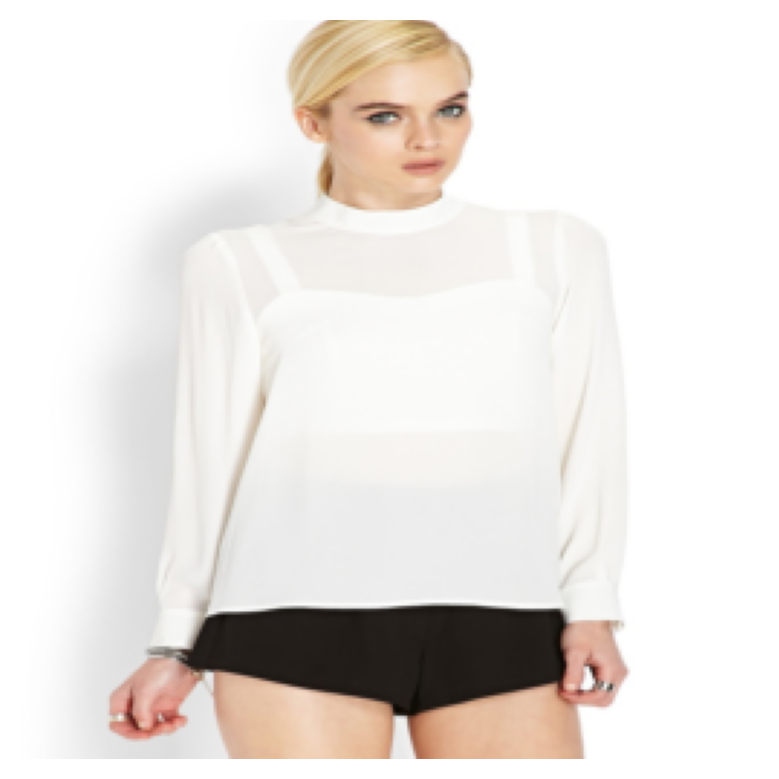

Sample 2:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg


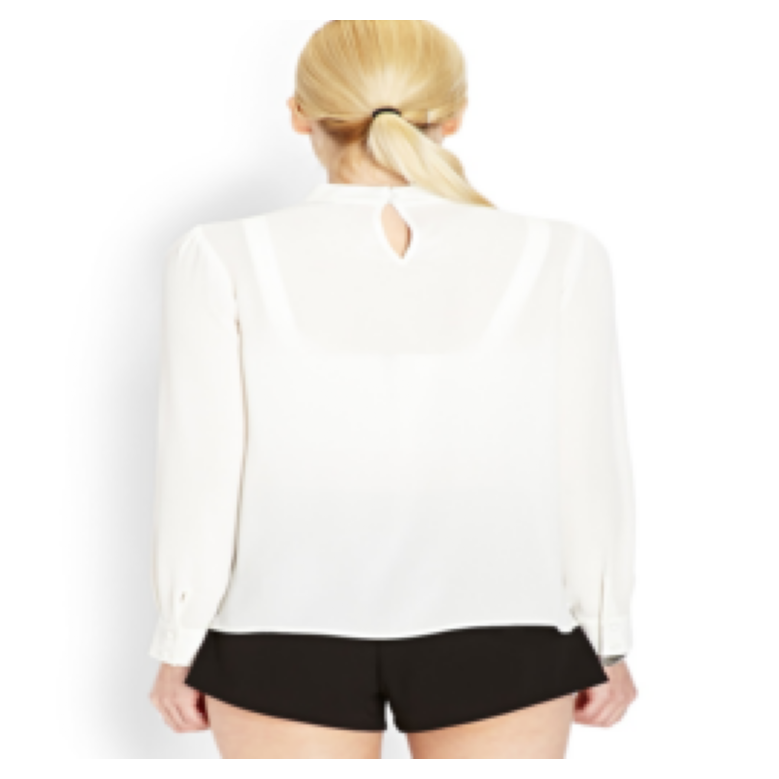

Sample 3:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Tees_Tanks/id_00000007/01_1_front.jpg


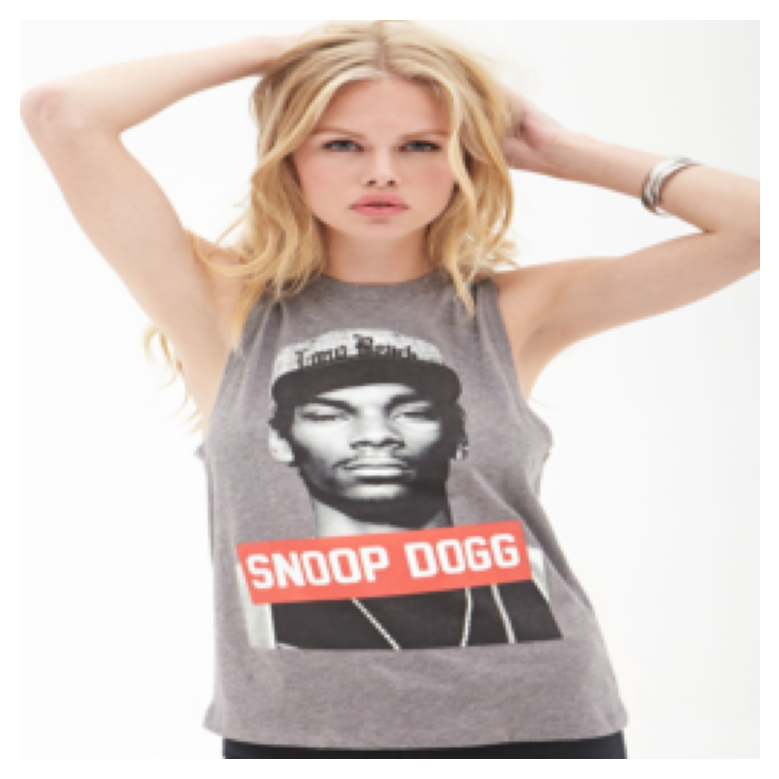

Sample 4:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Tees_Tanks/id_00000007/01_3_back.jpg


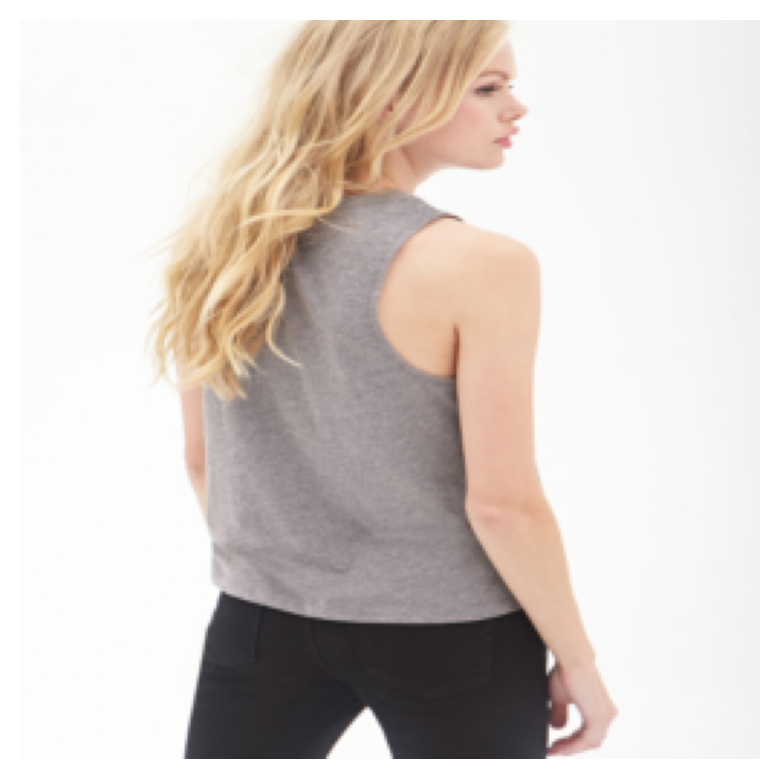

Sample 5:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Dresses/id_00000008/02_3_back.jpg


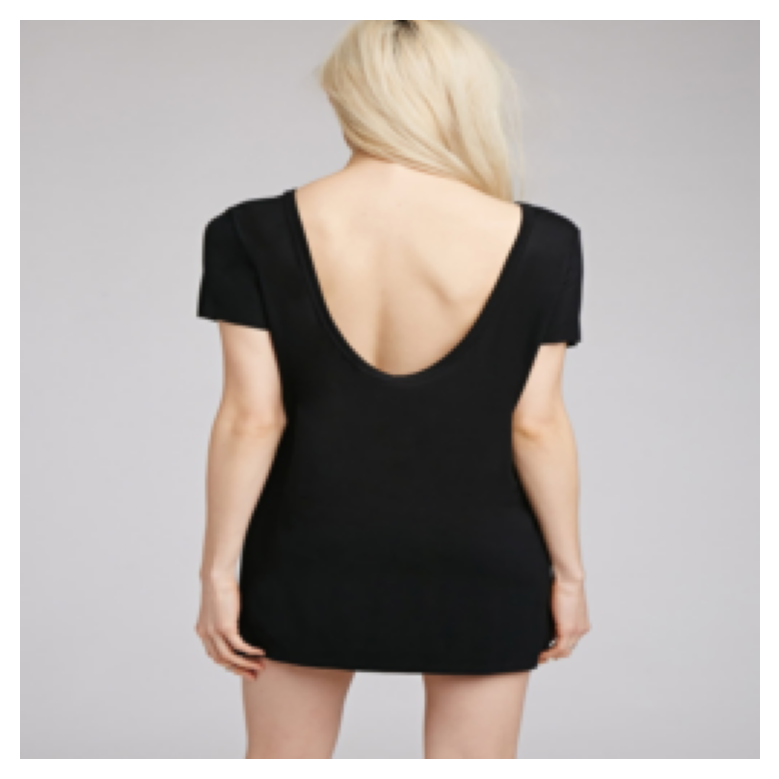

In [4]:
import matplotlib.pyplot as plt

# In ra số lượng ảnh trong dataset
print(f"Dataset có tổng cộng {len(gallery_dataset)} ảnh.")

# Lấy một vài ảnh từ dataset và hiển thị
def show_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, image_name = dataset[i]  # Lấy cả ảnh và tên ảnh
        if image is None:  # Trường hợp có ảnh lỗi
            print(f"Ảnh ở index {i} bị lỗi.")
            continue
        print(f"Sample {i + 1}:")
        print(f"   Tensor size: {image.shape}")
        print(f"   Image Name: {image_name}")  # In ra tên ảnh

        # Hiển thị ảnh
        plt.imshow(image.permute(1, 2, 0))  # Chuyển đổi từ (C, H, W) -> (H, W, C)
        plt.axis("off")
        plt.show()

# Hiển thị 5 mẫu ảnh
show_samples(gallery_dataset)


In [5]:
import os
import random
from torch.utils.data import Dataset
from PIL import Image

class customDataset2(Dataset):
    def __init__(self, root_dir, txt_path, transform=None, num_samples=100):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = {}
        self.data = []
        selected_ids = set()  # Tập hợp để lưu các item_id đã được chọn

        # Duyệt qua thư mục gốc và lưu đường dẫn ảnh
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(".jpg"):
                    relative_path = os.path.relpath(os.path.join(root, file), root_dir)
                    corrected_path = "/".join(relative_path.split("/")[1:])  # Bỏ cấp đầu tiên
                    self.image_paths[corrected_path] = os.path.join(root, file)

        # Đọc file txt chứa thông tin image_name, item_id và evaluation_status
        with open(txt_path, "r") as f:
            lines = f.readlines()

        # Duyệt qua file TXT để chọn ảnh duy nhất cho mỗi item_id
        for line in lines[2:]:
            parts = line.strip().split()
            image_name = parts[0]    # Đường dẫn ảnh từ TXT
            item_id = parts[1]       # Cột item_id
            evaluation_status = parts[2]

            # Chỉ chọn ảnh đầu tiên có trạng thái "query" cho mỗi item_id
            if evaluation_status == "query" and item_id not in selected_ids:
                if image_name in self.image_paths:  # Đảm bảo đường dẫn ảnh tồn tại
                    selected_ids.add(item_id)  # Thêm item_id vào set
                    self.data.append((image_name, self.image_paths[image_name]))

        # Lấy ngẫu nhiên 100 ảnh từ self.data (nếu đủ)
        self.data = random.sample(self.data, min(num_samples, len(self.data)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, img_path = self.data[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None  # Bỏ qua nếu có lỗi khi đọc ảnh
        
        if self.transform:
            image = self.transform(image)
        
        return image, image_name


In [6]:
from torchvision import transforms
# Đường dẫn đến dữ liệu
ROOT_DIR = "/kaggle/input/deepfashion1"  # Thay bằng thư mục chứa ảnh
CSV_PATH = "/kaggle/input/deepfashion1/updated_list_eval_partition.txt"  # Thay bằng đường dẫn file CSV

# Transform: Resize và Normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize ảnh
    transforms.ToTensor(),                         # Chuyển đổi ảnh thành tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize theo ImageNet Stats
])

query_dataset = customDataset2(ROOT_DIR, CSV_PATH, transform = transform)

Dataset có tổng cộng 100 ảnh.
Sample 1:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Shorts/id_00004192/01_1_front.jpg


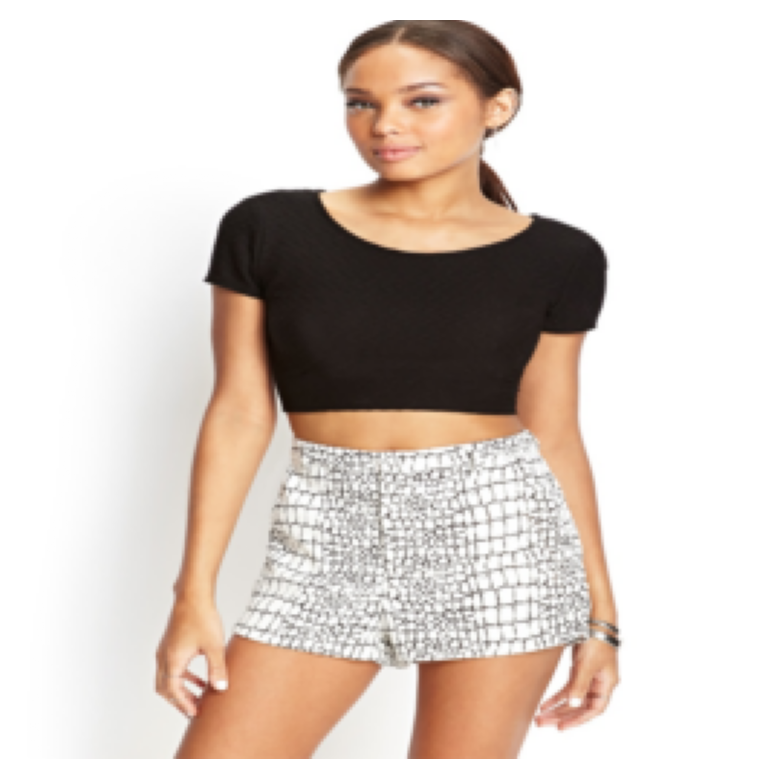

Sample 2:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Dresses/id_00000547/01_1_front.jpg


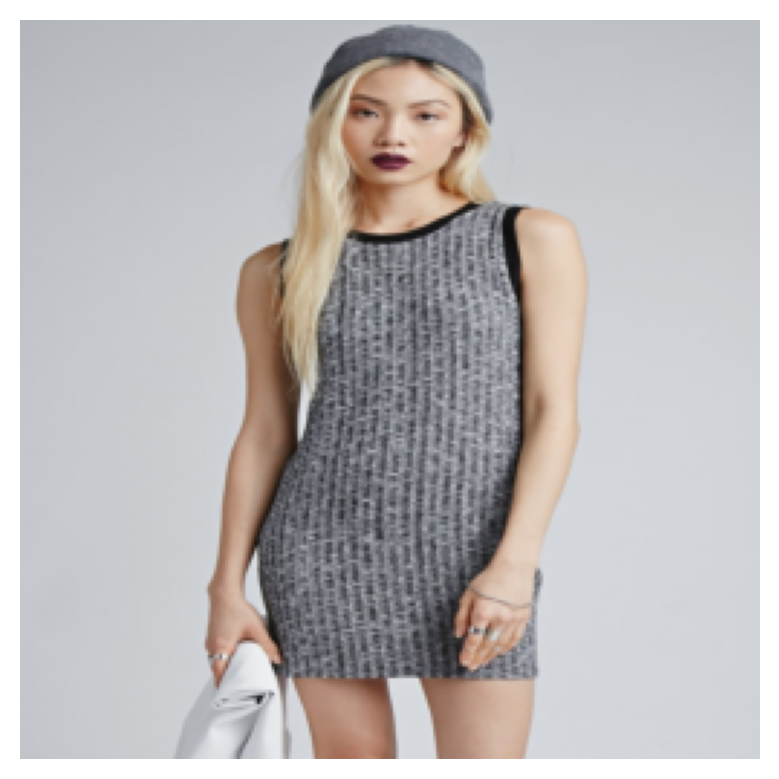

Sample 3:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Dresses/id_00004954/02_1_front.jpg


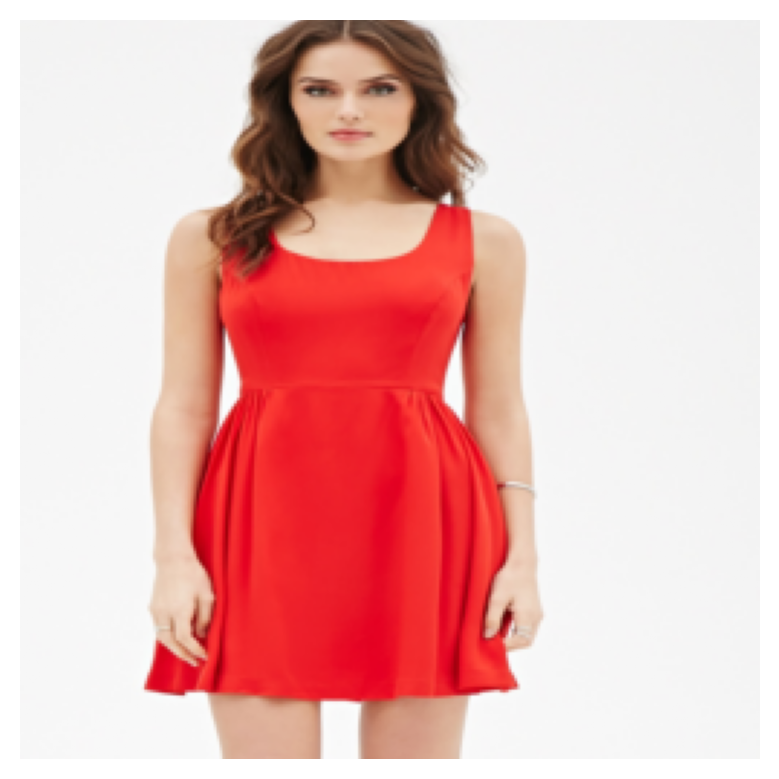

Sample 4:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Graphic_Tees/id_00006273/01_3_back.jpg


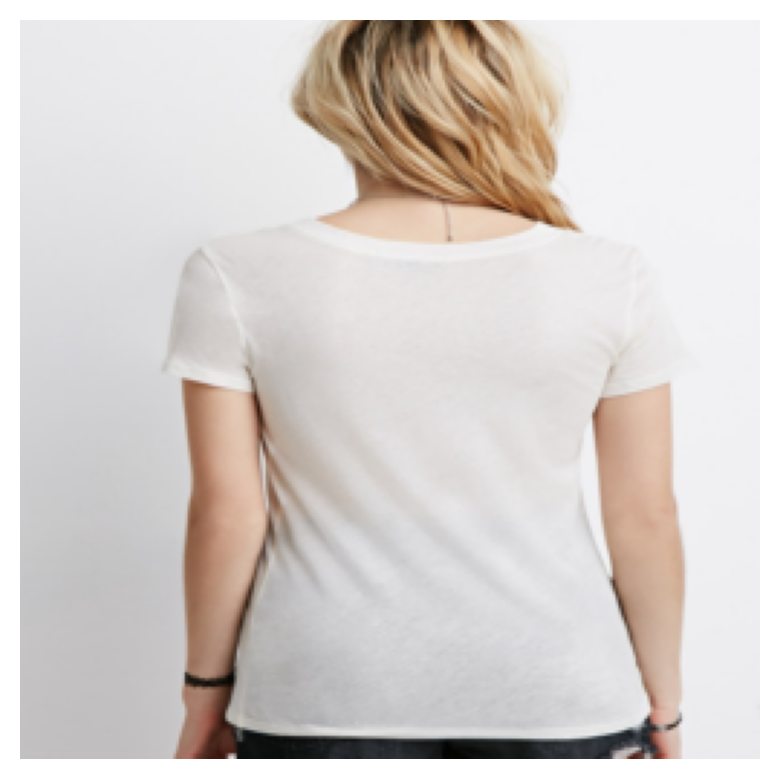

Sample 5:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Tees_Tanks/id_00003828/03_2_side.jpg


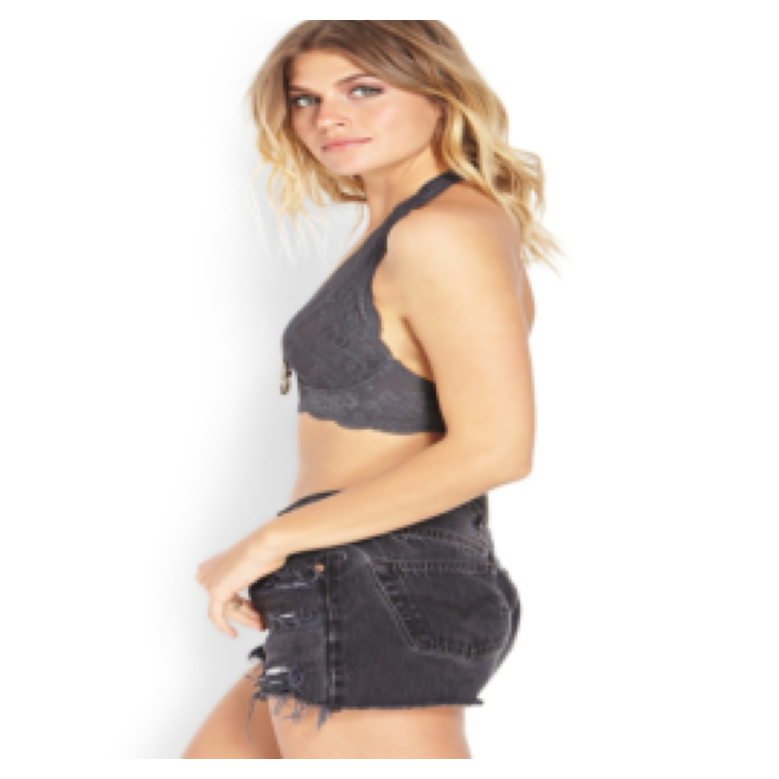

In [7]:
import matplotlib.pyplot as plt

# In ra số lượng ảnh trong dataset
print(f"Dataset có tổng cộng {len(query_dataset)} ảnh.")

# Lấy một vài ảnh từ dataset và hiển thị
def show_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, image_name = dataset[i]  # Lấy cả ảnh và tên ảnh
        if image is None:  # Trường hợp có ảnh lỗi
            print(f"Ảnh ở index {i} bị lỗi.")
            continue
        print(f"Sample {i + 1}:")
        print(f"   Tensor size: {image.shape}")
        print(f"   Image Name: {image_name}")  # In ra tên ảnh

        # Hiển thị ảnh
        plt.imshow(image.permute(1, 2, 0))  # Chuyển đổi từ (C, H, W) -> (H, W, C)
        plt.axis("off")
        plt.show()

# Hiển thị 5 mẫu ảnh
show_samples(query_dataset)


In [8]:
import torch
from skimage.feature import hog
import numpy as np
from tqdm import tqdm

def extract_vectors_batched(dataloader, flip=False, device="cpu"):
    """
    Trích xuất vector đặc trưng HOG từ DataLoader cho ảnh màu theo từng batch.

    Args:
        dataloader: DataLoader chứa dataset (ảnh dưới dạng Tensor).
        flip: Có áp dụng flipping để tăng cường dữ liệu hay không.
        device: Thiết bị thực thi ("cpu").
        
    Returns:
        Tensor chứa vector HOG RGB cho tất cả ảnh, danh sách tên ảnh.
    """
    n_flip = 2 if flip else 1  # Nếu flip, số ảnh mỗi batch sẽ gấp đôi
    n_img = len(dataloader.dataset) * n_flip  # Tổng số ảnh (bao gồm flipping nếu có)
    bs = dataloader.batch_size
    vectors = []
    image_names = []  # Danh sách tên ảnh

    for idx, (img_batch, img_names) in enumerate(tqdm(dataloader, desc="Extracting HOG Features for RGB")):
        st = idx * bs * n_flip
        fin = min((idx + 1) * bs * n_flip, n_img)
        
        # Chuyển batch ảnh về numpy
        img_batch = img_batch.to(device).cpu().numpy()
        
        for i, img in enumerate(img_batch):
            # Chuyển ảnh từ Tensor (C, H, W) sang định dạng (H, W, C)
            img = np.transpose(img, (1, 2, 0))  # (H, W, C)
            
            # Tính HOG cho từng kênh R, G, B
            hog_r = hog(img[:, :, 0], orientations=6, pixels_per_cell=(16, 16), 
                        cells_per_block=(1, 1), block_norm='L2-Hys', 
                        visualize=False, feature_vector=True)
            hog_g = hog(img[:, :, 1], orientations=6, pixels_per_cell=(16, 16), 
                        cells_per_block=(1, 1), block_norm='L2-Hys', 
                        visualize=False, feature_vector=True)
            hog_b = hog(img[:, :, 2], orientations=6, pixels_per_cell=(16, 16), 
                        cells_per_block=(1, 1), block_norm='L2-Hys', 
                        visualize=False, feature_vector=True)
            
            # Ghép HOG của 3 kênh lại thành 1 vector
            hog_feature_rgb = np.hstack([hog_r, hog_g, hog_b])
            vectors.append(hog_feature_rgb)  # Thêm vector HOG
            
            # Xử lý flipping nếu cần
            if flip:
                img_flipped = np.fliplr(img)  # Flip ảnh ngang

                # Tính HOG cho từng kênh của ảnh flipped
                hog_r_flip = hog(img_flipped[:, :, 0], orientations=6, pixels_per_cell=(16, 16), 
                                 cells_per_block=(1, 1), block_norm='L2-Hys', 
                                 visualize=False, feature_vector=True)
                hog_g_flip = hog(img_flipped[:, :, 1], orientations=6, pixels_per_cell=(16, 16), 
                                 cells_per_block=(1, 1), block_norm='L2-Hys', 
                                 visualize=False, feature_vector=True)
                hog_b_flip = hog(img_flipped[:, :, 2], orientations=6, pixels_per_cell=(16, 16), 
                                 cells_per_block=(1, 1), block_norm='L2-Hys', 
                                 visualize=False, feature_vector=True)
                
                # Ghép HOG của ảnh flipped
                hog_feature_rgb_flip = np.hstack([hog_r_flip, hog_g_flip, hog_b_flip])
                vectors.append(hog_feature_rgb_flip)  # Thêm vector flipped
                
                # Lưu tên ảnh
                image_names.append(img_names[i])
                image_names.append(img_names[i] + "_flip")
            else:
                image_names.append(img_names[i])  # Lưu tên ảnh gốc

    # Chuyển danh sách vector HOG thành tensor
    vectors = np.array(vectors)  # Chuyển thành mảng numpy
    vectors = torch.tensor(vectors, dtype=torch.float32)  # Chuyển thành tensor PyTorch

    return vectors, image_names


In [9]:
import os
import torch
from torch.utils.data import DataLoader

# Hàm trích xuất đặc trưng và lưu cache
def extract_and_cache_features(dataloader, feature_file, flip=False, device="cuda"):
    """
    Trích xuất và lưu các vector đặc trưng từ dataloader.

    Args:
        dataloader: PyTorch DataLoader.
        model: Mô hình trích xuất đặc trưng.
        feature_file: Tên file để lưu/tải vector đặc trưng.
        flip: Áp dụng flipping dữ liệu nếu True.
        device: Thiết bị thực thi ("cuda" hoặc "cpu").
    Returns:
        Tensor các vector đặc trưng.
    """
    p_flip = 'flip' if flip else ''  # Tạo tên file dựa trên flip

    # Kiểm tra file đã tồn tại hay chưa
    if os.path.exists(feature_file):
        print(f"Loading {feature_file} from disk...", end=" ")
        features = torch.load(feature_file)
        print("OK")
    else:
        print(f"Failed to load {feature_file}. Extracting features...")
        features = extract_vectors_batched(dataloader, flip=flip, device=device)
        torch.save(features, feature_file)
        print(f"Features saved to {feature_file}.")
    return features

# Đường dẫn lưu các file đặc trưng
# Đường dẫn lưu file trong Kaggle
output_dir = "/kaggle/working/"  # Lưu file tạm thời trong Kaggle Notebook

# Tạo đường dẫn đầy đủ cho file cache
query_feature_file = os.path.join(output_dir, "query_flip_HOG_100.pt")
gallery_feature_file = os.path.join(output_dir, "gallery_flip_HOG_100.pt")

# Model trích xuất đặc trưng
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tạo DataLoader cho query và train datasets
query_dataloader = DataLoader(query_dataset, batch_size=16, shuffle=False, num_workers=4)
gallery_dataloader = DataLoader(gallery_dataset, batch_size=16, shuffle=False, num_workers=4)


# Trích xuất hoặc load các vector đặc trưng
query_features, query_image_names = extract_and_cache_features(query_dataloader, query_feature_file, flip=True, device=device)
gallery_features, gallery_image_names = extract_and_cache_features(gallery_dataloader, gallery_feature_file, flip=True, device=device)

# In kết quả
print(f"Gallery features shape: {gallery_features.shape}")
print(f"Gallery image names: {gallery_image_names[:5]}")  # Hiển thị tên của 5 ảnh đầu tiên


Failed to load /kaggle/working/query_flip_HOG_100.pt. Extracting features...


Extracting HOG Features for RGB: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Features saved to /kaggle/working/query_flip_HOG_100.pt.
Failed to load /kaggle/working/gallery_flip_HOG_100.pt. Extracting features...


Extracting HOG Features for RGB: 100%|██████████| 789/789 [14:51<00:00,  1.13s/it]


Features saved to /kaggle/working/gallery_flip_HOG_100.pt.
Gallery features shape: torch.Size([25224, 4608])
Gallery image names: ['WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg_flip', 'WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg_flip', 'WOMEN/Tees_Tanks/id_00000007/01_1_front.jpg']


In [10]:
query_features, gallery_features

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2906, 0.0000],
         [0.5677, 0.5677, 0.0000,  ..., 0.5824, 0.4010, 0.0000],
         ...,
         [0.4985, 0.4985, 0.0785,  ..., 0.5953, 0.2993, 0.0000],
         [0.5000, 0.5000, 0.0000,  ..., 0.5385, 0.3606, 0.0000],
         [0.5537, 0.5537, 0.0000,  ..., 0.5101, 0.4268, 0.1928]]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0285, 0.1008, 0.5176],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4446, 0.4446, 0.1795,  ..., 0.5574, 0.4697, 0.2285],
         [0.5559, 0.5559, 0.0815,  ..., 0.4649, 0.4649, 0.1130],
         [0.5581, 0.5581, 0.0000,  ..., 0.5560, 0.1495, 0.2241]]))

In [11]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.2 MB/s eta 0:00:000:00:0100:01


In [12]:
import faiss
import itertools
from pathlib import Path

# Hàm flatten dùng để làm phẳng danh sách 2 chiều
def flatten(list2d):
    return list(itertools.chain(*list2d))

# Lấy đường dẫn ảnh từ dataset (không rút gọn tên ảnh)
query_fnames = flatten([[image_name,image_name] for _, image_name in query_dataset])
index_fnames = flatten([[image_name,image_name] for _, image_name in gallery_dataset])

print("Query file paths:", query_fnames[:5])   # In ra 5 đường dẫn đầu tiên trong query_fnames
print("Index file paths:", index_fnames[:5])   # In ra 5 đường dẫn đầu tiên trong index_fnames


Query file paths: ['WOMEN/Shorts/id_00004192/01_1_front.jpg', 'WOMEN/Shorts/id_00004192/01_1_front.jpg', 'WOMEN/Dresses/id_00000547/01_1_front.jpg', 'WOMEN/Dresses/id_00000547/01_1_front.jpg', 'WOMEN/Dresses/id_00004954/02_1_front.jpg']
Index file paths: ['WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg', 'WOMEN/Tees_Tanks/id_00000007/01_1_front.jpg']


In [17]:
import numpy as np
from tqdm import tqdm
import re

# def t_pcawhitenlearn(X):

#     N = X.shape[0]

#     # Learning PCA w/o annotations
#     m = X.mean(dim=0, keepdim=True)
#     Xc = X - m
#     Xcov = Xc.t() @ Xc
#     Xcov = (Xcov + Xcov.t()) / (2*N)
#     eigval, eigvec = torch.symeig(Xcov,eigenvectors=True)
#     order = eigval.argsort(descending=True)
#     eigval = eigval[order]
#     eigvec = eigvec[:, order]

#     P = torch.inverse(torch.sqrt(torch.diag(eigval))) @ eigvec.t()

#     return m, P
def t_pcawhitenlearn(X):
    N = X.shape[0]

    m = X.mean(dim=0, keepdim=True)
    Xc = X - m
    Xcov = Xc.t() @ Xc
    Xcov = (Xcov + Xcov.t()) / (2 * N)
    
    # Thay thế torch.symeig bằng torch.linalg.eigh
    eigval, eigvec = torch.linalg.eigh(Xcov)
    
    # Sắp xếp giá trị riêng và vectơ riêng theo thứ tự giảm dần
    order = eigval.argsort(descending=True)
    eigval = eigval[order]
    eigvec = eigvec[:, order]

    # Tính ma trận làm trắng P
    P = torch.inverse(torch.sqrt(torch.diag(eigval))) @ eigvec.t()

    return m, P

def t_whitenapply(X, m, P, dimensions=None):

    if not dimensions: dimensions = P.shape[1]

    X = (X-m) @ P[:,:dimensions]
    X = X / (torch.norm(X, dim=1, keepdim=True) + 1e-6)
    return X

def get_idxs_and_dists(_query_features, _index_features, index_type='', BS = 32):

    if True:
        index_transforms = []
        for index_transform in index_type.split(','):
            m = re.match(r'PCAW(\d+)?', index_transform)
            if m is not None:
                dimensions = int(m[1]) if m[1] is not None else _index_features.shape[-1]
                print(f"Applying {dimensions} PCA, Whitening and L2Norm...", end="")
                m, P = t_pcawhitenlearn(_index_features)
                _index_features = t_whitenapply(_index_features, m, P,dimensions=dimensions).unsqueeze(1)
                _query_features = t_whitenapply(_query_features, m, P,dimensions=dimensions).unsqueeze(1)
                print("done")

            elif index_transform not in ['L2norm']: index_transforms.append(index_transform)

        index_type = ','.join(index_transforms)
        print(index_type)
    else:
         _index_features = _index_features.unsqueeze(1)
         _query_features = _query_features.unsqueeze(1)

    if isinstance(_query_features, torch.Tensor): query_features = _query_features.numpy()
    if isinstance(_index_features, torch.Tensor): index_features = _index_features.numpy()
    max_hits = 20

    n_patches = query_features.shape[1]
    n_queries = query_features.shape[0]

    print(query_features.shape, index_features.shape, n_queries, n_patches)

    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.device = 0
    res = faiss.StandardGpuResources()
    co = faiss.GpuMultipleClonerOptions()
    co.shard=True
    co.shard_type=1
    co.useFloat16=False
    index_features = index_features.squeeze(1)  # Remove the extra singleton dimension
    query_features = query_features.squeeze(1)  # Remove the extra singleton dimension
    print(index_features.shape)  # Should print (num_samples, num_dimensions)
    print(query_features.shape)  # Should print (num_queries, num_dimensions)
    _index = faiss.index_factory(index_features.shape[1], index_type)#, faiss.METRIC_INNER_PRODUCT)
    try:
        index = _index #faiss.index_cpu_to_all_gpus(_index,co=co) #
        print("Index in GPU")
    except:
        index = _index
        print("Index in CPU")
    print("Training index...", end="")
    index.train(index_features)
    print("done")
    print("Adding features to index...", end="")
    index.add(index_features)
    print("done")
    out_dists = np.zeros((len(query_features), max_hits), dtype=np.float32)
    out_idxs  = np.zeros((len(query_features), max_hits), dtype=np.int32)
    NUM_QUERY = len (query_features)
    for ind in tqdm(range(0, len(query_features), BS), desc="Querying FAISS index"):
        fin = ind + BS
        if fin > NUM_QUERY: 
            fin = NUM_QUERY
        q_descs = query_features[ind:fin]
        D, I = index.search(q_descs, max_hits)
        out_dists[ind:fin] = D
        out_idxs[ind:fin] = I // n_patches
    # Thêm return ở cuối hàm
    return out_idxs, out_dists


In [13]:
import faiss
import numpy as np
from tqdm import tqdm
import re
def t_pcawhitenlearn(X):
    N = X.shape[0]

    m = X.mean(dim=0, keepdim=True)
    Xc = X - m
    Xcov = Xc.t() @ Xc
    Xcov = (Xcov + Xcov.t()) / (2 * N)
    
    # Thay thế torch.symeig bằng torch.linalg.eigh
    eigval, eigvec = torch.linalg.eigh(Xcov)
    
    # Sắp xếp giá trị riêng và vectơ riêng theo thứ tự giảm dần
    order = eigval.argsort(descending=True)
    eigval = eigval[order]
    eigvec = eigvec[:, order]

    # Tính ma trận làm trắng P
    P = torch.inverse(torch.sqrt(torch.diag(eigval))) @ eigvec.t()

    return m, P

def t_whitenapply(X, m, P, dimensions=None):

    if not dimensions: dimensions = P.shape[1]

    X = (X-m) @ P[:,:dimensions]
    X = X / (torch.norm(X, dim=1, keepdim=True) + 1e-6)
    return X
def get_idxs_and_dists(_query_features, _index_features, index_type='', BS = 32):

    if True:
        index_transforms = []
        for index_transform in index_type.split(','):
            m = re.match(r'PCAW(\d+)?', index_transform)
            if m is not None:
                dimensions = int(m[1]) if m[1] is not None else _index_features.shape[-1]
                print(f"Applying {dimensions} PCA, Whitening and L2Norm...", end="")
                m, P = t_pcawhitenlearn(_index_features)
                _index_features = t_whitenapply(_index_features, m, P, dimensions=dimensions).unsqueeze(1)
                _query_features = t_whitenapply(_query_features, m, P, dimensions=dimensions).unsqueeze(1)
                print("done")

            elif index_transform not in ['L2norm']: 
                index_transforms.append(index_transform)

        index_type = ','.join(index_transforms)
        print(index_type)
    else:
        _index_features = _index_features.unsqueeze(1)
        _query_features = _query_features.unsqueeze(1)

    if isinstance(_query_features, torch.Tensor): 
        query_features = _query_features.numpy()
    if isinstance(_index_features, torch.Tensor): 
        index_features = _index_features.numpy()
    
    max_hits = 20
    n_patches = query_features.shape[1]
    n_queries = query_features.shape[0]

    print(query_features.shape, index_features.shape, n_queries, n_patches)
    index_features = index_features.squeeze(1)  # Remove the extra singleton dimension
    query_features = query_features.squeeze(1)  # Remove the extra singleton dimension
    print(index_features.shape[1])
    # Chọn IVF với Product Quantization (PQ)
    nlist = 1024  # số nhóm (clusters)
    nsubquantizers = 16  # Số sub-quantizers
    nbits = 8  # Số bits cho mỗi sub-quantizer

    # Tạo quantizer (sử dụng IndexFlatL2 làm quantizer)
    quantizer = faiss.IndexFlatL2(index_features.shape[1])

    # Tạo chỉ mục IVF với PQ
    index = faiss.IndexIVFPQ(quantizer, index_features.shape[1], nlist, nsubquantizers, nbits)
    
    # Huấn luyện chỉ mục IVF với PQ
    print("Training index...", end="")
    index.train(index_features)  # Huấn luyện với dữ liệu mẫu
    print("done")

    # Thêm các đặc trưng vào chỉ mục IVF với PQ
    print("Adding features to index...", end="")
    index.add(index_features)  # Thêm các đặc trưng vào chỉ mục
    print("done")
    
    out_dists = np.zeros((len(query_features), max_hits), dtype=np.float32)
    out_idxs  = np.zeros((len(query_features), max_hits), dtype=np.int32)
    NUM_QUERY = len(query_features)

    # Tìm kiếm trong chỉ mục IVF với PQ
    for ind in tqdm(range(0, len(query_features), BS), desc="Querying FAISS index"):
        fin = ind + BS
        if fin > NUM_QUERY: 
            fin = NUM_QUERY
        q_descs = query_features[ind:fin]
        D, I = index.search(q_descs, max_hits)
        out_dists[ind:fin] = D
        out_idxs[ind:fin] = I // n_patches
    
    return out_idxs, out_dists


In [14]:
faiss.omp_get_max_threads()

2

In [15]:
# Squeeze out the singleton dimensions
gallery_features = gallery_features.squeeze(1).squeeze(1)  # Remove the extra singleton dimensions
query_features = query_features.squeeze(1).squeeze(1)  # Remove the extra singleton dimensions

print("Shape of index_features:", gallery_features.shape)  # Should print (25224, 2048)
print("Shape of query_features:", query_features.shape)  # Should print (num_queries, 2048)

Shape of index_features: torch.Size([25224, 4608])
Shape of query_features: torch.Size([200, 4608])


In [18]:
#faiss.omp_set_num_threads(31)
index_type=f"PCAW{query_features.shape[-1]},L2norm,Flat"
#index_type="PCAW512,L2norm,IVF4096,PQ16"
#index_type="Flat"

#out_idxs, out_dists = get_idxs_and_dists(
#    torch.cat((query_features[0],query_features[1]),dim=-1).squeeze(1),
#    torch.cat((index_features[0],index_features[1]),dim=-1).squeeze(1), BS = 32*4, index_type=index_type)
out_idxs, out_dists = get_idxs_and_dists(
    query_features,
    gallery_features, index_type=index_type, BS = 32*4 )

Applying 4608 PCA, Whitening and L2Norm...done
Flat
(200, 1, 4608) (25224, 1, 4608) 200 1
(25224, 4608)
(200, 4608)
Index in GPU
Training index...done
Adding features to index...done


Querying FAISS index: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


In [16]:
#faiss.omp_set_num_threads(31)
index_type=f"PCAW{query_features.shape[-1]},L2norm,IVF4096"
#index_type="PCAW512,L2norm,IVF4096,PQ16"
#index_type="Flat"

#out_idxs, out_dists = get_idxs_and_dists(
#    torch.cat((query_features[0],query_features[1]),dim=-1).squeeze(1),
#    torch.cat((index_features[0],index_features[1]),dim=-1).squeeze(1), BS = 32*4, index_type=index_type)
out_idxs, out_dists = get_idxs_and_dists(
    query_features,
    gallery_features, index_type=index_type, BS = 32*4 )

Applying 4608 PCA, Whitening and L2Norm...done
IVF4096
(200, 1, 4608) (25224, 1, 4608) 200 1
4608
Training index...

WARNING clustering 25224 points to 1024 centroids: please provide at least 39936 training points


done
Adding features to index...done


Querying FAISS index: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


In [17]:
np.sort(out_dists.reshape((-1,int(out_idxs.shape[1]*1))), axis=1)

array([[0.45409948, 0.4544784 , 0.45818213, ..., 0.4964549 , 0.49653625,
        0.49714667],
       [0.4075924 , 0.42168888, 0.42415905, ..., 0.4386056 , 0.43904656,
        0.43958032],
       [0.67401814, 0.6764997 , 0.68553764, ..., 0.7246681 , 0.7250274 ,
        0.7266458 ],
       ...,
       [0.6715008 , 0.6955842 , 0.6981194 , ..., 0.7169236 , 0.71854556,
        0.71861404],
       [0.7846915 , 0.7866736 , 0.7930767 , ..., 0.81054664, 0.81062156,
        0.8116449 ],
       [0.80435026, 0.81962377, 0.82465935, ..., 0.85324514, 0.8549826 ,
        0.8550649 ]], dtype=float32)

In [31]:
np.save(f'idx.npy',  out_idxs)
np.save(f'dist.npy', out_dists)

In [18]:
import os
import csv

# Đọc file TXT chứa thông tin ảnh
txt_path = '/kaggle/input/deepfashion1/updated_list_eval_partition.txt'  # Đường dẫn tới file TXT
root_dir = '/kaggle/input/deepfashion1/images'  # Đường dẫn tới thư mục chứa ảnh (nếu cần)

# Tạo danh sách chứa các ảnh có evaluation_status = "query"
data = []

with open(txt_path, 'r') as f:
    lines = f.readlines()

# Bỏ qua dòng đầu tiên và header
for line in lines[2:]:
    parts = line.strip().split()
    image_name = parts[0]  # Tên ảnh
    evaluation_status = parts[2]  # Trạng thái đánh giá

    # Kiểm tra nếu evaluation_status = "query"
    if evaluation_status == "query":
        # Thêm image_name vào danh sách
        data.append(image_name)

# Đặt tên file và lưu query.csv
output_file = '/kaggle/working/query.csv'  # Đường dẫn nơi file sẽ được lưu

with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['images']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Ghi header
    writer.writeheader()

    # Ghi từng dòng dữ liệu
    for image_name in data:
        writer.writerow({'images': image_name})

print(f"query.csv đã được tạo thành công và lưu tại {output_file}.")


query.csv đã được tạo thành công và lưu tại /kaggle/working/query.csv.


In [19]:
import pandas as pd
sub_fname = 'test_submission.csv'
sample_df = pd.read_csv('query.csv')
sample_df['images'] = ''

In [20]:
out_idxs[0]//2, out_idxs[1]//2

(array([ 5994,  4349,  8496,  7256,   762,  2776,  3617,  2467, 12175,
        10520,  1149,   895, 12302,  9506, 12300,  8989,   303,  4178,
         2122,  9950], dtype=int32),
 array([12254,  4043,   910,  4685,   762, 10205,  7883,  7713, 10520,
         4332,  6700,  7254, 10999,  4349,  2008,  3323, 12028,  8504,
         1460,  3356], dtype=int32))

In [21]:
i = 2
idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)
dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0)
u_idx = np.unique(idx,return_index=True)[1]
i_dst = dst[u_idx]
o_dst =np.argsort(i_dst)
print(idx, o_dst, i_dst)
print(idx[u_idx[o_dst]]//2)

i = 2
idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)//2
dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0)
u_idx = np.unique(idx,return_index=True)[1]
i_dst = dst[u_idx]
o_dst =np.argsort(i_dst)
print(idx, o_dst, i_dst)
print(idx[u_idx[o_dst]])

[21357 10019   556  4517 22097 13121  4462  8476 21609  8164  1087 14608
 18904  9891   564  9943   512 20057 25036 11847 13189 16298 11910   612
 23770 18292 14206 24594 23733 24546 15419 10450  7619 11591 13992 11906
   666 15738 11350  2268] [32 14  1  8 34 21  7 11 33 10  5 25 30 12  2 13 22  0 31 39 18 28 20  3
 36 29 24 38 35 37 26 15  9 17 23 19  4 27 16  6] [0.722812   0.68553764 0.7201966  0.73062605 0.7789323  0.7153757
 0.77995855 0.701581   0.68881035 0.77724123 0.7117858  0.70647264
 0.7173785  0.72094786 0.6764997  0.77666354 0.7794505  0.7778145
 0.7266458  0.7788793  0.728184   0.6986904  0.7210109  0.7781719
 0.75928146 0.7164204  0.7754591  0.77898085 0.72735363 0.74751824
 0.71644944 0.7246681  0.67401814 0.71018416 0.6952677  0.76735187
 0.74552923 0.7703284  0.7629862  0.7250274 ]
[10678  5009   278  2258 11048  6560  2231  4238 10804  4082   543  7304
  9452  4945   282  4971  6594   256 10028 12518  5923  8149  5955   306
 11885  9146  7103 12297 11866 12273  770

In [22]:
sub = {}
for i, query_fname in tqdm(enumerate(query_fnames), total=len(query_fnames), desc="Processing queries"):
    if i % 2: 
        continue
    
    # Kiểm tra để tránh vượt quá chỉ mục
    if i + 1 >= len(out_idxs):  # Nếu i+1 vượt quá kích thước mảng, bỏ qua
        continue
    
    idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0) // 2
    dst = np.concatenate([out_dists[i], out_dists[i+1]], axis=0)
    
    u_idx = np.unique(idx, return_index=True)[1]
    i_dst = dst[u_idx]
    o_dst = np.argsort(i_dst)
    _out_idxs = idx[u_idx[o_dst]]

    ids = [index_fnames[x*2] for x in _out_idxs[:10]]
    sub[query_fname] = ' '.join(ids)


Processing queries: 100%|██████████| 200/200 [00:00<00:00, 17243.13it/s]


In [23]:
sub_df = pd.DataFrame({'id' : list(sub.keys()), 'images':list(sub.values())})
sub_df = pd.concat([sub_df, sample_df]).drop_duplicates(subset=['id'])
sub_df.to_csv(sub_fname, index=False)

In [24]:
sub_df.iloc[:8]

id  \
0         WOMEN/Shorts/id_00004192/01_1_front.jpg   
1        WOMEN/Dresses/id_00000547/01_1_front.jpg   
2        WOMEN/Dresses/id_00004954/02_1_front.jpg   
3    WOMEN/Graphic_Tees/id_00006273/01_3_back.jpg   
4      WOMEN/Tees_Tanks/id_00003828/03_2_side.jpg   
5     WOMEN/Tees_Tanks/id_00006196/03_1_front.jpg   
6        WOMEN/Dresses/id_00002536/03_1_front.jpg   
7  WOMEN/Jackets_Coats/id_00004877/03_1_front.jpg   

                                              images  
0  WOMEN/Shorts/id_00007759/04_1_front.jpg WOMEN/...  
1  WOMEN/Dresses/id_00006855/05_7_additional.jpg ...  
2  WOMEN/Dresses/id_00003007/02_3_back.jpg WOMEN/...  
3  WOMEN/Blouses_Shirts/id_00003822/03_7_addition...  
4  WOMEN/Blouses_Shirts/id_00005888/03_2_side.jpg...  
5  WOMEN/Dresses/id_00002442/01_2_side.jpg WOMEN/...  
6  WOMEN/Dresses/id_00003332/04_1_front.jpg WOMEN...  
7  WOMEN/Sweatshirts_Hoodies/id_00004520/01_1_fro...

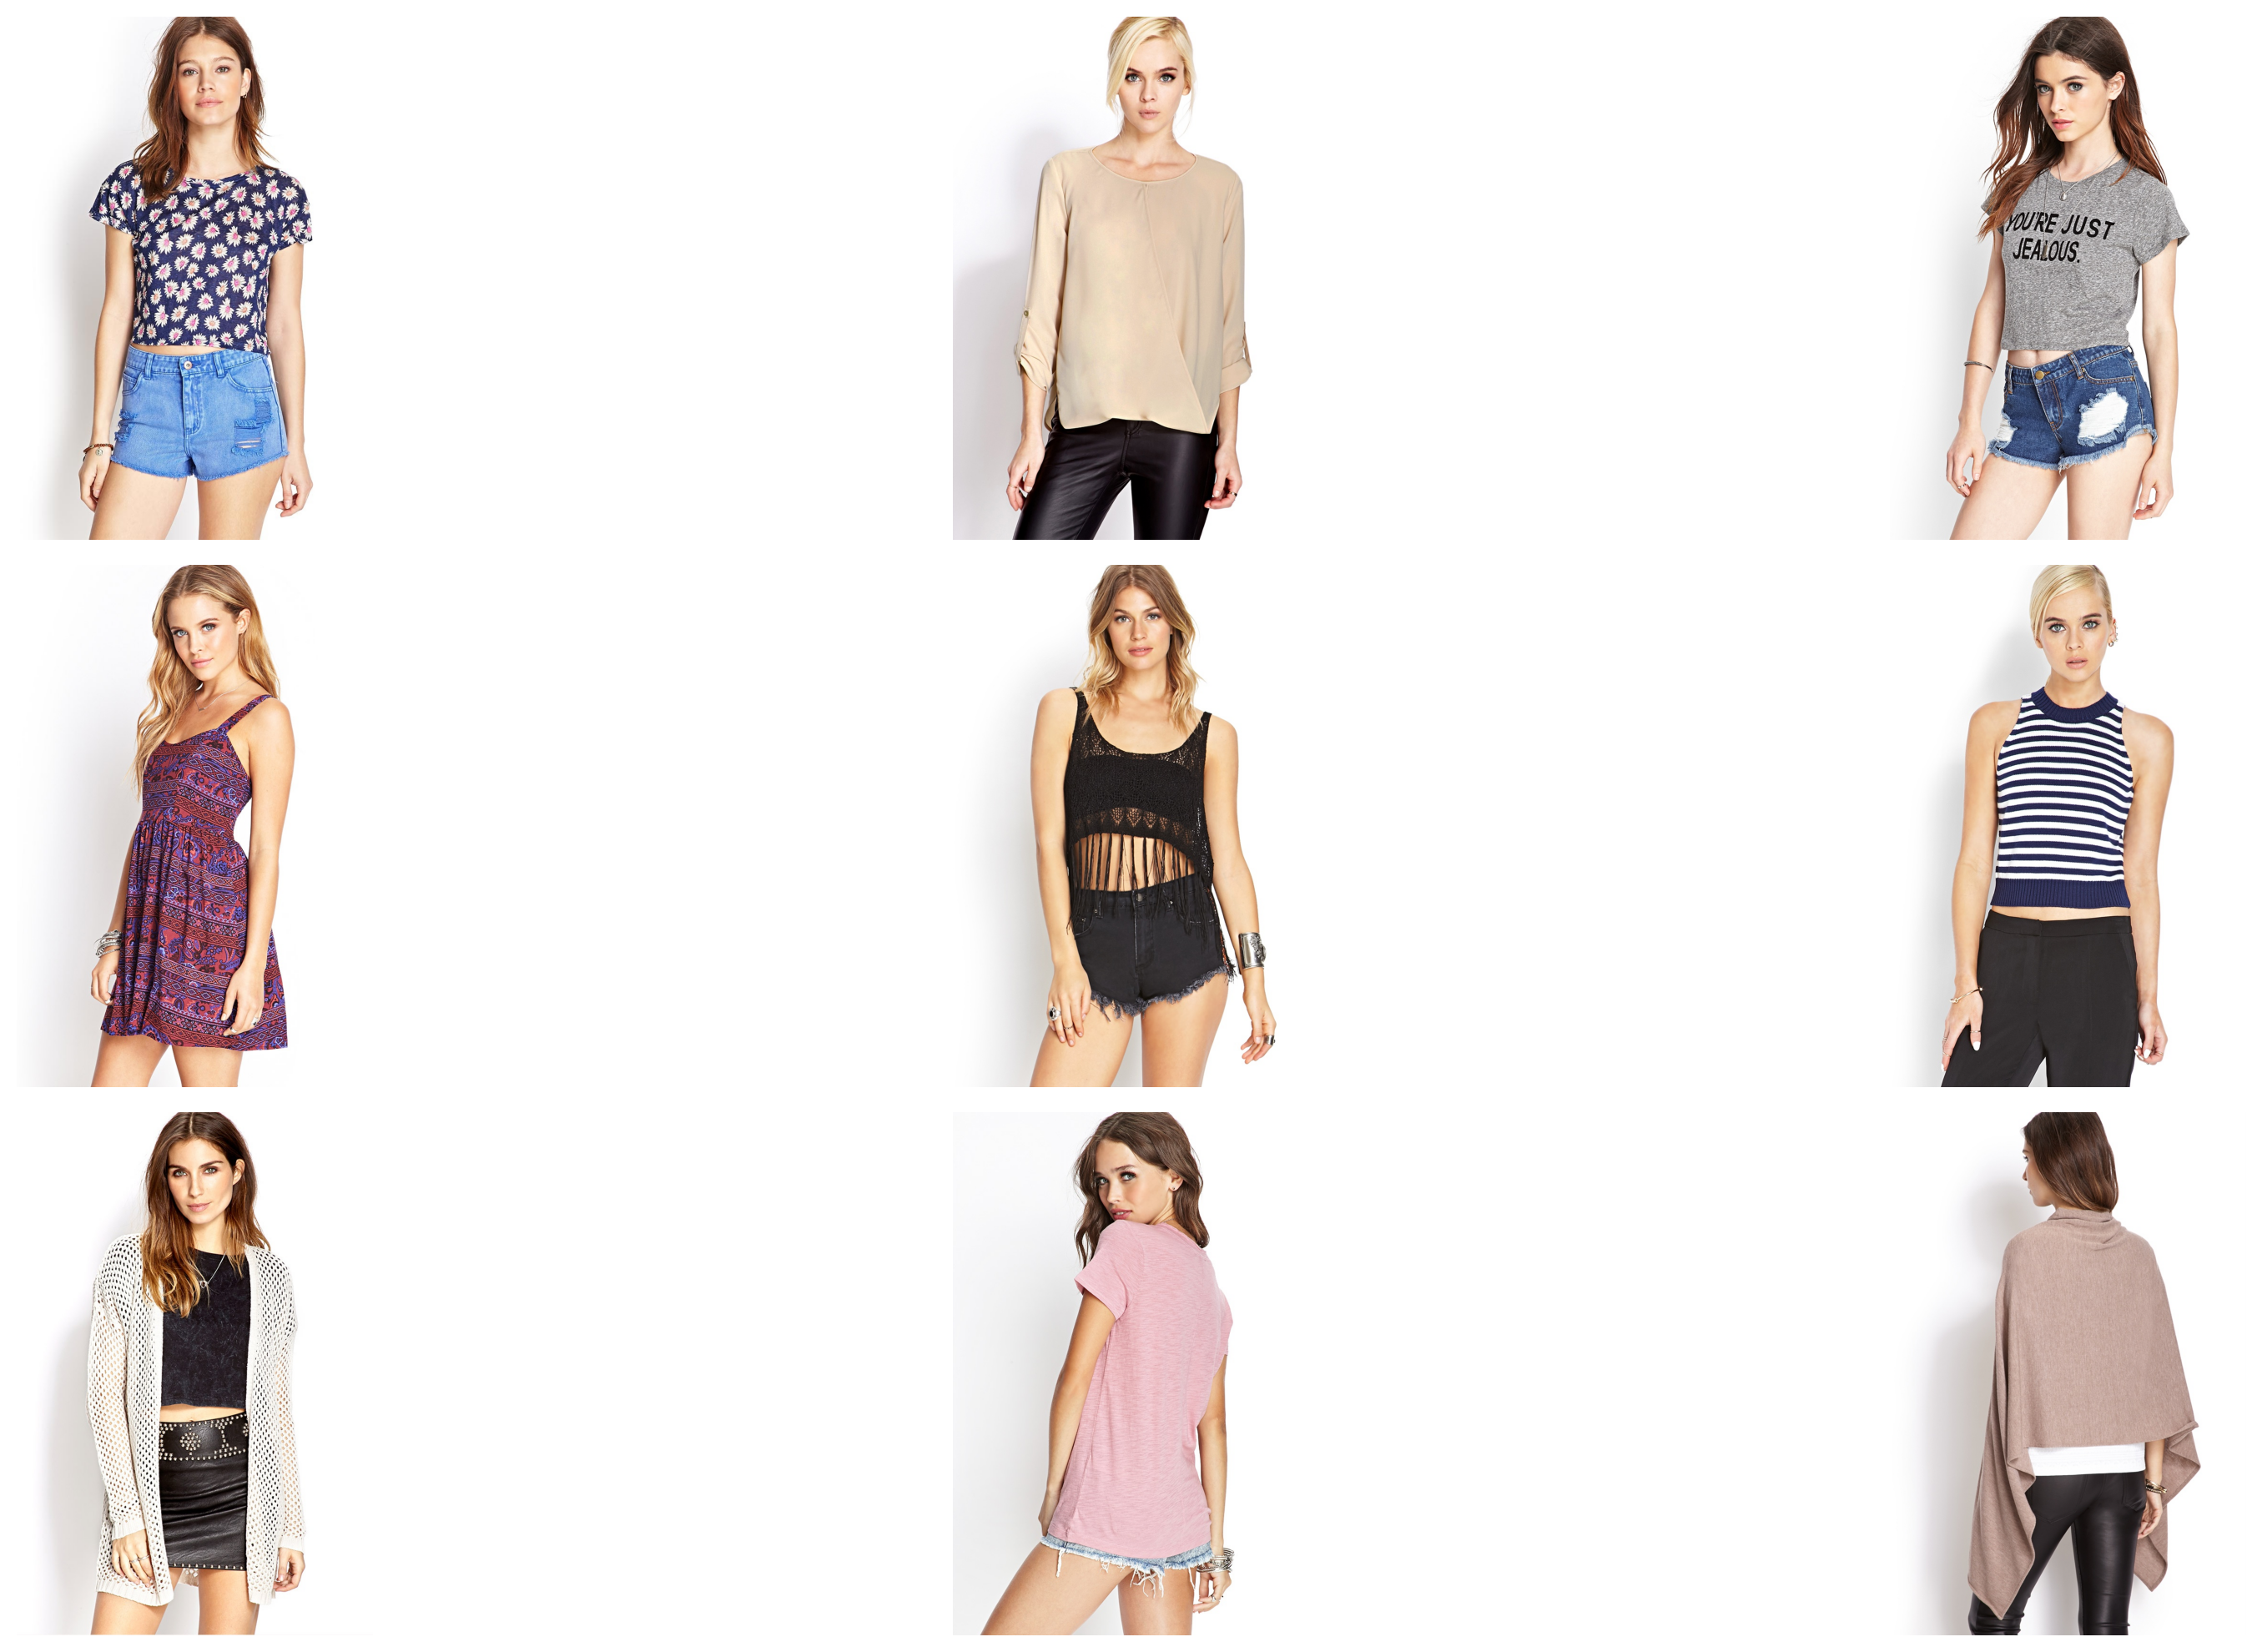

In [27]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def fix_path(p):
    # Lấy tên tệp tin
    fn = str(p.name)
    
    # Kiểm tra xem p có "WOMEN" hoặc "MEN" ở phần đầu hay không
    if p.parts[0] == "WOMEN":
        return Path("/kaggle/input/deepfashion1/WOMEN") / p  # Nếu là "WOMEN", thêm "WOMEN"
    elif p.parts[0] == "MEN":
        return Path("/kaggle/input/deepfashion1/MEN") / p  # Nếu là "MEN", thêm "MEN"
    else:
        return Path("/kaggle/input/deepfashion1") / p  # Trường hợp khác, giữ nguyên

# Hàm lấy ảnh và kết quả từ dataframe
def image_results(row, n=9):  # Change n to 9 for 9 images
    # 9 ảnh kết quả từ cột 'images' (bao gồm cả ảnh query đầu tiên)
    result_images = [Image.open(fix_path(Path(id))).convert("RGB") for id in row.images.split(' ')[:n]]

    return result_images

# Hàm để hiển thị các ảnh
def show_all(images, r=3, c=3, figsize=(20, 10)):  # Update r and c to fit 3 rows and 3 columns
    fig, axs = plt.subplots(r, c, figsize=figsize)  # Tạo lưới subplots (3 rows, 3 columns)
    axs = axs.flatten()  # Chuyển thành mảng 1 chiều để dễ thao tác

    # Duyệt qua và hiển thị các ảnh
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')  # Tắt hiển thị trục của ảnh

    plt.tight_layout()  # Căn chỉnh các ảnh hợp lý
    plt.show()

# Ví dụ sử dụng show_all với dataframe
# Hiển thị ảnh của row thứ 3 trong dataframe sub_df, bao gồm cả ảnh query (ảnh đầu tiên)
show_all(image_results(sub_df.iloc[0], n=9), r=3, c=3, figsize=(20, 10))
